## 1) Problem: Create Generative Adversarial Network (GAN) to recreate Monet painting
Monet has a popular sytle of painting that has last the test of time, since his death in 1926. His style of painting is using colorful, but muted pastel colors. His painting have a unique flow and waviness to them yet the subjects and landscapes are realistic. This is a difficult style for an individual to imitate let alone an AI model. 

However, I will attempt to create a GAN model that will attempt to create Monet paintings. 


#### Generative Adversarial Network (GAN)
The GAN model is based off of creating 2 models that are essentially competing against eachother. Which is why it is considered an adversarial model. 

The first model will generate a Monet painting, while the other model will predict whether or not the first model's output image is a real or fake. That cycle will iterate many times to train the generative model. 

#### Importing the libraries

In [59]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LayerNormalization

import matplotlib.pyplot as plt
import numpy as np

import pydot
import graphviz
import PIL

Configure to use TPU GPU, or CPU based on availability.

In my case I will be running on GPU.

In [66]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
        if tf.config.list_physical_devices('GPU'):
            strategy = tf.distribute.MirroredStrategy()
            print("Running on GPU.")
        else:
            strategy = tf.distribute.get_strategy()
            print("Running on CPU.")

print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Running on CPU.
Number of replicas: 1
2.18.0


## Loading in the data
First I am loading in the filenames of the TFRecords for monet and photos

In [5]:
MONET_FILENAMES = tf.io.gfile.glob('CU Boulder/Intro to Deep Learning/Week 5/Data/monet_tfrec/*.tfrec')
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob('CU Boulder/Intro to Deep Learning/Week 5/Data/photo_tfrec/*.tfrec')
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


The shape of the images are 256x256 in jpeg and tfrec formation. The channel is set to 3 as these are RGB images.

In [7]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

Function that extracts the images from the files.

In [9]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

Loading the datasets.

In [84]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

## 2) Exploratory Data Analysis

Since the data itself is just images there is not much EDA that I am aware of needing. I will create a bar graph of the count of the Monet paintings and other images. I will also display example Monets and images, but that is it. 

In [13]:
# pick a monet picture and a photo from the data sets
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

Here are examples of a photo and a real monet.

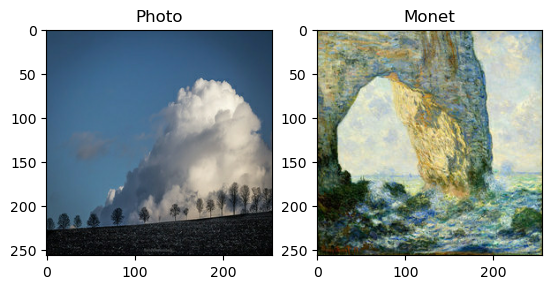

In [78]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

In our data there are 300 real Monets and 7038 images. 

There is a much higher number of images compared to the small number of Monets. This is due to not all of Monets paintings captured in the data due to them being lost to history and the contrant size of 256x256.

Number of images in Monet directory:  300
Number of images in photo directory:  7038


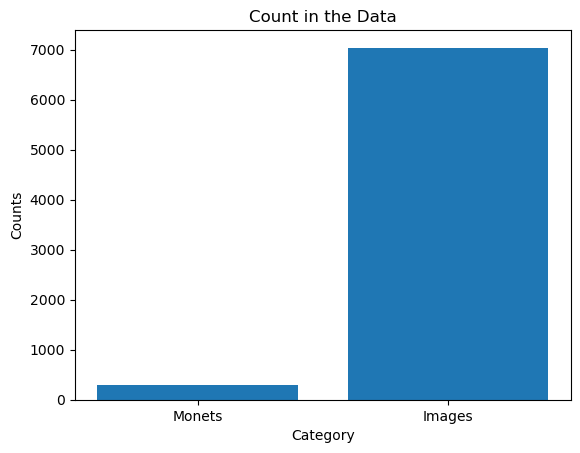

In [86]:
MONET_JPG = tf.io.gfile.glob('CU Boulder/Intro to Deep Learning/Week 5/Data/monet_jpg/*.jpg')

PHOTO_JPG = tf.io.gfile.glob('CU Boulder/Intro to Deep Learning/Week 5/Data/photo_jpg/*.jpg')

# Display number of files in Monet and Photo directories
print('Number of images in Monet directory: ', len(MONET_JPG))
print('Number of images in photo directory: ', len(PHOTO_JPG))

counts = [len(MONET_JPG), len(PHOTO_JPG)]
labels = ['Monets', 'Images']

plt.bar(labels, counts)

plt.xlabel('Category')
plt.ylabel('Counts')
plt.title('Count in the Data')

plt.show()

## 3) Creating the model

#### Creating the generator

A generator model has 2 parts. An encoder which turns the image into data that can be read by the model. The 2nd part is a decoder which takes in the encoded data and recreates it into an image.

We'll be using a UNET architecture for our CycleGAN.

A U-Net consists of an encoder (downsampler) and decoder (upsampler).

Each block in the encoder is: Convolution -> Batch normalization -> Leaky ReLU

Each block in the decoder is: Transposed convolution -> Batch normalization -> Dropout -> ReLU There are skip connections between the encoder and decoder (as in the U-Net).-Net).

This this case the encoder reduces the width and height of the image by 2, applying a filter to every other pixel. 

In [19]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(
            tf.keras.layers.LayerNormalization(
                gamma_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02),
                axis=-1,  # Normalize along the last axis
                epsilon=1e-5  # Default epsilon, can be adjusted
            )
        )
    result.add(layers.LeakyReLU())
    return result

The decoder upsamples the data and increases the dimensions of the data

In [21]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    # Equivalent to InstanceNormalization
    result.add(
        tf.keras.layers.LayerNormalization(
            gamma_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02),
            axis=-1,  # Normalize along the last axis
            epsilon=1e-5  # Default epsilon, can be adjusted
        )
    )
    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

#### Generator

The generator downsamples the input image and then upsamples and establishes skip connections. Skip connections preserve image information and help bypass the vanishing gradient problem by concatenating the output of a layer to multiple layers. 

In [23]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

#### Building the discriminator

The discrimnator takes the input image and classifies it as real or fake. The output will be a value between 0 to 1. A value closer to 0 means the discrimator predicts the input image is a fake while a value closer to 1 means the discrimator predicts the image to be real. 

In [29]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tf.keras.layers.GroupNormalization(groups=1,  # Groups of 1 channel mimic instance normalization
                                                gamma_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02),
                                                epsilon=1e-5
                                                )(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [35]:
discriminator = Discriminator()
# tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [37]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

In [41]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

#### Defining the loss functions

The discrimator loss function below compares the real images to a matrix of 1s and fake images to a matrix of 0s. The perfect discriminator will output all 1s for real images and all 0s for fake images. The discriminator loss outputs the average of the real and generated loss. 

In [43]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

The generator wants to fool the discriminator. The perfect generator will have the discriminator output only 1s. Therefore, it compares the generated image to the matrix of 1s to find the loss.

In [45]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

We want our original photo and the twice transformed photo to be similar to one another. Thus, we can calculate the cycle consistency loss be finding the average of their difference.

In [47]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

The identity loss compares the image with its generator (i.e. photo with photo generator). If given a photo as input, we want it to generate the same image as the image was originally a photo. The identity loss compares the input with the output of the generator.

In [49]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

#### Training the CycleGAN

I will cycle through 25 epochs for the model to train on

In [51]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [53]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [55]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=25
)

Epoch 1/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 741s 2s/step - monet_disc_loss: 0.6023 - monet_gen_loss: 6.3953 - photo_disc_loss: 0.5899 - photo_gen_loss: 6.6049
Epoch 2/25


C:\Users\bendu\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


300/300 ━━━━━━━━━━━━━━━━━━━━ 698s 2s/step - monet_disc_loss: 0.6232 - monet_gen_loss: 3.8504 - photo_disc_loss: 0.6578 - photo_gen_loss: 3.7744
Epoch 3/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 702s 2s/step - monet_disc_loss: 0.6100 - monet_gen_loss: 3.7213 - photo_disc_loss: 0.6504 - photo_gen_loss: 3.6313
Epoch 4/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 696s 2s/step - monet_disc_loss: 0.5926 - monet_gen_loss: 3.7929 - photo_disc_loss: 0.6312 - photo_gen_loss: 3.6509
Epoch 5/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 697s 2s/step - monet_disc_loss: 0.6041 - monet_gen_loss: 3.5516 - photo_disc_loss: 0.6506 - photo_gen_loss: 3.4455
Epoch 6/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 708s 2s/step - monet_disc_loss: 0.5957 - monet_gen_loss: 3.3503 - photo_disc_loss: 0.6467 - photo_gen_loss: 3.2310
Epoch 7/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 708s 2s/step - monet_disc_loss: 0.6103 - monet_gen_loss: 3.1814 - photo_disc_loss: 0.6291 - photo_gen_loss: 3.1506
Epoch 8/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 694s 2s/step - monet_disc_loss: 0.5899 - 

#### Visualize the generated Monet images

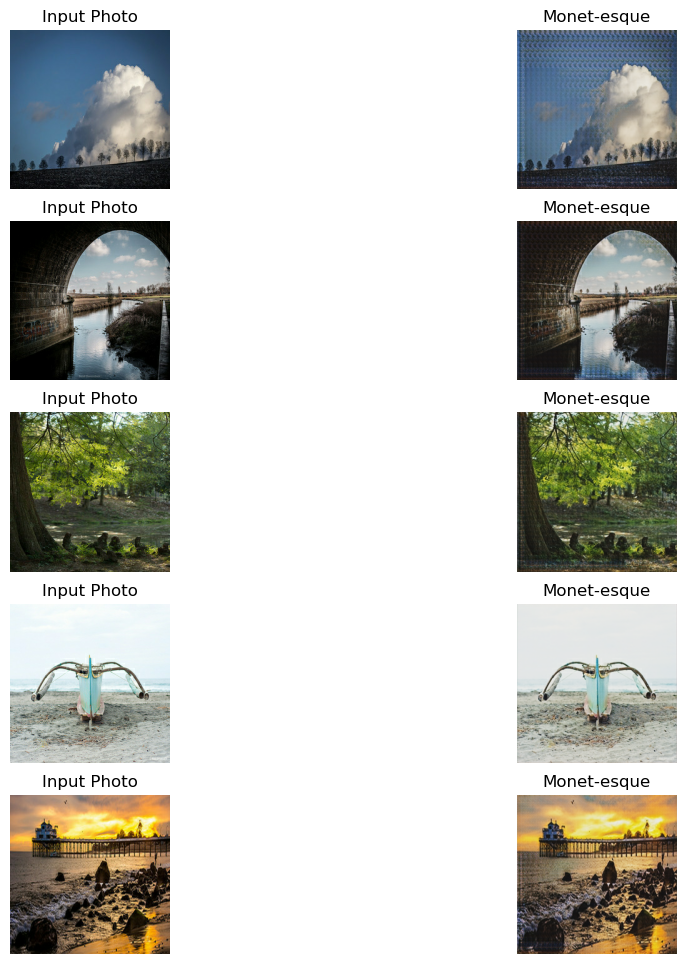

In [63]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

## 2) Creating submission file

In [108]:
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("C:/Users/bendu/CU Boulder/Intro to Deep Learning/Week 5/Submission/" + str(i) + ".jpg")
    i += 1